# Sales Forecasting: Modeling
1. Split data into training/testing
2. SARIMA
3. Prophet
4. RandomForest
5. LSTM


In [99]:
import pandas as pd
import numpy as np
import re
import plotly.express as px
import seaborn as sns
from datetime import datetime
import dateutil.relativedelta

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from prophet import Prophet
from neuralprophet import NeuralProphet
import warnings
warnings.filterwarnings('ignore')


#### Load data in

In [2]:
# load in sales CSV data
orders = pd.read_csv("orders.csv",parse_dates=True)
returns = pd.read_csv("returns.csv",parse_dates=True)
people = pd.read_csv("people.csv",parse_dates=True)

# remove returns from orders dataset
df = (orders
      .merge(right=returns, left_on='Order ID', right_on='Order ID', how='left')
      .merge(right=people, left_on = 'Region', right_on = 'Region', how='left'))

# fill instances when returned is NaN as "NO"
df['Returned'] = df['Returned'].fillna('No')

# remove returned sales orders
df = df[df['Returned'] == 'No']

# convert order date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# create dt column
df['ds'] = pd.to_datetime(df['Order Date'].dt.strftime('%Y-%m'))

# final data series 
df = df.groupby(['ds','Region']).agg(sales=('Sales','sum')).reset_index()
df = df.rename({'sales':'y'},axis=1)

#### Split data training/testing

Training : 2014-2016
Testing : 2017
Prediction windw : 3 months out

In [199]:
def datepart(dataframe, fldname):
    df = dataframe
    df_ds = pd.to_datetime(df[fldname])
    df['dayofmonth'] = df_ds.dt.day
    df['dayofweek'] = df_ds.dt.dayofweek
    df['dayofyear'] = df_ds.dt.dayofyear
    df['year'] = df_ds.dt.year
    df['month'] = df_ds.dt.month
    df['day'] = df_ds.dt.day
    df['hour'] = df_ds.dt.hour
    df['quarter'] = df_ds.dt.quarter
    df['is_year_start'] = df_ds.dt.is_year_start
    df['is_year_end'] = df_ds.dt.is_year_end
    
    df = df.drop(fldname, axis=1)
    
    return df
    
def split_train_test(df, window, test_period):
    '''

    '''
    train = []
    test = []

    for i in range(test_period,window-1,-1):
        test_start_date = df.ds.max() - dateutil.relativedelta.relativedelta(months=i)
        test_end_date = test_start_date + dateutil.relativedelta.relativedelta(months=window)
        train.append(df[df.ds <= test_start_date])
        test.append(df[(df.ds > test_start_date) & (df.ds <= test_end_date)])

    return train, test
    
            
def prophet(train, test):
    yhat = []
    y = []
    month = []
    pred_len = []
    for i in range(len(train)):
        m = Prophet()
        m.fit(train[i])
        pred = m.predict(test[i])
        yhat.append(pred.yhat)
        y.append(test[i])
        month.append(test[i].ds.dt.month)
        pred_len.append(pd.DataFrame([1,2,3]))

    yhat = pd.concat(yhat).rename('yhat')
    month = pd.concat(month).rename('month')
    pred_len = pd.concat(pred_len)

    result = pd.concat(y)
    result['yhat'] = yhat.values
    result['month'] = month.values
    result['pred_len'] = pred_len.values
    result['e'] = result.y - result.yhat    
    result['ae'] = abs(result.e)
    result['ape'] = abs(result.y - result.yhat)/result.y
    
    return result

def neuralprophet(train, test):
    yhat = []
    y = []
    month = []
    pred_len = []
    for i in range(len(train)):
        m = NeuralProphet()
        m.fit(train[i].reset_index(drop=True),freq='M')
        pred = m.predict(test[i].reset_index(drop=True))
        yhat.append(pred.yhat1)
        y.append(test[i].reset_index(drop=True))
        month.append(test[i].ds.dt.month)
        pred_len.append(pd.DataFrame([1,2,3]))

    yhat = pd.concat(yhat).rename('yhat')
    month = pd.concat(month).rename('month')
    pred_len = pd.concat(pred_len)

    result = pd.concat(y)
    result['yhat'] = yhat.values
    result['month'] = month.values
    result['pred_len'] = pred_len.values
    result['e'] = result.y - result.yhat    
    result['ae'] = abs(result.e)
    result['ape'] = abs(result.y - result.yhat)/result.y
    
    return result



In [426]:
def split_train_test(df, window, test_period):
    '''

    '''
    train_dict = dict()
    test_dict = dict()

    # get unique regions
    regions = df.Region.unique()
    
    for region in regions:
        train = []
        test = []
        df_region = df[df.Region == region][['ds','y']]
        for i in range(test_period,window-1,-1):
            test_start_date = df_region.ds.max() - dateutil.relativedelta.relativedelta(months=i)
            test_end_date = test_start_date + dateutil.relativedelta.relativedelta(months=window)
            train.append(df_region[df_region.ds <= test_start_date])
            test.append(df_region[(df_region.ds > test_start_date) & (df_region.ds <= test_end_date)])

        # append to dictionary
        train_dict.update({f'{region}':train})
        test_dict.update({f'{region}':test})
    
    return train_dict, test_dict

def prophet(train_df, test_df):
    final_result = []
    for region in train_dict.keys():
        yhat = []
        y = []
        month = []
        pred_len = []
        train = train_df[region]
        test = test_df[region]
        for i in range(len(train)):
            m = Prophet()
            m.fit(train[i])
            pred = m.predict(test[i])
            yhat.append(pred.yhat)
            y.append(test[i])
            month.append(test[i].ds.dt.month)
            pred_len.append(pd.DataFrame([1,2,3]))

        yhat = pd.concat(yhat).rename('yhat')
        month = pd.concat(month).rename('month')
        pred_len = pd.concat(pred_len)

        result = pd.concat(y)
        result['region'] = region
        result['yhat'] = yhat.values
        result['month'] = month.values
        result['pred_len'] = pred_len.values
        result['e'] = result.y - result.yhat    
        result['ae'] = abs(result.e)
        result['ape'] = abs(result.y - result.yhat)/result.y
        final_result.append(result)
    
    final_result = pd.concat(final_result)
    
    return final_result

def neuralprophet(train_df, test_df):
    final_result = []
    for region in train_dict.keys():
        yhat = []
        y = []
        month = []
        pred_len = []
        train = train_df[region]
        test = test_df[region]
        for i in range(len(train)):
            m = NeuralProphet()
            m.fit(train[i].reset_index(drop=True),freq='M')
            pred = m.predict(test[i].reset_index(drop=True))
            yhat.append(pred.yhat1)
            y.append(test[i].reset_index(drop=True))
            month.append(test[i].ds.dt.month)
            pred_len.append(pd.DataFrame([1,2,3]))

        yhat = pd.concat(yhat).rename('yhat')
        month = pd.concat(month).rename('month')
        pred_len = pd.concat(pred_len)

        result = pd.concat(y)
        result['region'] = region
        result['yhat'] = yhat.values
        result['month'] = month.values
        result['pred_len'] = pred_len.values
        result['e'] = result.y - result.yhat    
        result['ae'] = abs(result.e)
        result['ape'] = abs(result.y - result.yhat)/result.y
        final_result.append(result)
    
    final_result = pd.concat(final_result)
    
    return final_result

# Prophet vs NeuralProphet

Here I compare Prophet with Neural Prophet. The prediction window is 3 months out and we use all available historical data to make the forecast. 

In [427]:
# get training data
train_dict,test_dict = split_train_test(df, 3,12)

results_prophet = prophet(train_dict,test_dict)
results_neuralprophet = neuralprophet(train_dict,test_dict)


18:42:42 - cmdstanpy - INFO - Chain [1] start processing
18:42:42 - cmdstanpy - INFO - Chain [1] done processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing
18:42:44 - cmdstanpy - INFO - Chain [1] start processing
18:42:45 - cmdstanpy - INFO - Chain [1] done processing
18:42:45 - cmdstanpy - INFO - Chain [1] start processing
18:42:45 - cmdstanpy - INFO - Chain [1] done processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] done processing
18:42:47 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
18:42:48 - cmdstanpy - INFO - Chain [1] start processing
18:42:48 - cmdstanpy - INFO - Chain [1] done processing
18:42:48 - cmdstanpy - INFO - Chain [1] start processing
18:42:48 - cmdstanpy - INFO - Chain [1] done processing
18:42:49 - cmdstanpy - INFO - Chain [1] start processing
18:42:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 1.15E+00


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 4.15E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.15E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 236.72it/s, SmoothL1Loss=0.013, MAE=
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-SUN corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-SUN corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major freque

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 1.15E+00


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 2.58E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.15E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 240.21it/s, SmoothL1Loss=0.0136, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-WED corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-WED corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major freque

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 7.63E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.16E-02, min: 9.35E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 239.49it/s, SmoothL1Loss=0.0163, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 9.35E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 1.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.15E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 238.97it/s, SmoothL1Loss=0.0171, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.16E-02, min: 7.63E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 2.11E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 239.25it/s, SmoothL1Loss=0.0178, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.44E-02, min: 1.00E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.15E+00, min: 1.00E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.72E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 238.17it/s, SmoothL1Loss=0.0175, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.22E-01, min: 1.72E+00


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 1.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.97E-01
Epoch[991/991]: 100%|█| 991/991 [00:04<00:00, 238.39it/s, SmoothL1Loss=0.0165, MAE=3.4
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.372% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly 

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 9.35E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 1.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.07E-01
Epoch[974/974]: 100%|█| 974/974 [00:04<00:00, 237.47it/s, SmoothL1Loss=0.0166, MAE=3.3
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 3.87E+00


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 1.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
Epoch[956/956]: 100%|█| 956/956 [00:04<00:00, 237.83it/s, SmoothL1Loss=0.0155, MAE=3.2
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/104 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.54E-01, min: 1.79E+00


  0%|          | 0/104 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.37E-01, min: 7.48E-07
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.06E-01
Epoch[940/940]: 100%|█| 940/940 [00:03<00:00, 236.50it/s, SmoothL1Loss=0.015, MAE=3.19
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.76E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.16E-02, min: 4.15E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.35E-02
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 236.47it/s, SmoothL1Loss=0.00388, MA
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-SUN corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-SUN corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major freque

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.66E-02, min: 6.22E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.44E-02, min: 9.35E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.66E-02
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 236.44it/s, SmoothL1Loss=0.00371, MA
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-WED corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-WED corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major freque

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.15E-01, min: 6.22E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.44E-02, min: 1.50E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.23E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 235.82it/s, SmoothL1Loss=0.0032, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.66E-02, min: 6.22E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.66E-02, min: 3.38E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.63E-02
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 235.96it/s, SmoothL1Loss=0.0031, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.16E-02, min: 9.35E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.66E-02, min: 5.08E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.16E-02
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 236.03it/s, SmoothL1Loss=0.00336, MA
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.84E-01, min: 2.76E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.62E-02, min: 1.84E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.73E-02
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 236.72it/s, SmoothL1Loss=0.00469, MA
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.16E-02, min: 1.50E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.16E-02, min: 2.58E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.73E-02
Epoch[991/991]: 100%|█| 991/991 [00:04<00:00, 235.01it/s, SmoothL1Loss=0.00526, MAE=2.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.372% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly 

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.44E-02, min: 7.63E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.44E-02, min: 1.84E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.22E-02
Epoch[974/974]: 100%|█| 974/974 [00:04<00:00, 234.94it/s, SmoothL1Loss=0.00491, MAE=2.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 6.22E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 1.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.15E-01
Epoch[956/956]: 100%|█| 956/956 [00:04<00:00, 234.03it/s, SmoothL1Loss=0.00536, MAE=2.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/104 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.85E-02, min: 1.31E-01


  0%|          | 0/104 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.91E-02, min: 7.15E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.12E-02
Epoch[940/940]: 100%|█| 940/940 [00:04<00:00, 234.30it/s, SmoothL1Loss=0.00723, MAE=2.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 1.40E+00


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.84E-01, min: 4.15E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.23E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 233.44it/s, SmoothL1Loss=0.037, MAE=
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-SUN corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-SUN corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major freque

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.44E-02, min: 9.35E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 5.08E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.16E-02
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 234.83it/s, SmoothL1Loss=0.0373, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-WED corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-WED corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major freque

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.84E-01, min: 8.73E+00


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.50E-01, min: 3.16E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.40E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 233.77it/s, SmoothL1Loss=0.0393, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.76E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.40E+00, min: 1.23E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.41E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 234.10it/s, SmoothL1Loss=0.0372, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 1.15E+00


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.25E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 233.92it/s, SmoothL1Loss=0.0413, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.84E-01, min: 3.16E+00


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.84E-01, min: 1.72E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.50E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 233.95it/s, SmoothL1Loss=0.0506, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.15E-01, min: 6.22E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.44E-02, min: 1.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.23E-01
Epoch[991/991]: 100%|█| 991/991 [00:04<00:00, 234.07it/s, SmoothL1Loss=0.0503, MAE=2.8
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.372% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly 

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.50E-01, min: 3.38E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.25E-01, min: 7.63E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.50E-01
Epoch[974/974]: 100%|█| 974/974 [00:04<00:00, 233.11it/s, SmoothL1Loss=0.0494, MAE=2.7
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 5.08E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.76E-01, min: 7.63E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.50E-01
Epoch[956/956]: 100%|█| 956/956 [00:04<00:00, 233.19it/s, SmoothL1Loss=0.0479, MAE=2.7
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/104 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.58E-01, min: 6.54E-01


  0%|          | 0/104 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.07E-01, min: 2.67E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.56E-01
Epoch[940/940]: 100%|█| 940/940 [00:04<00:00, 232.68it/s, SmoothL1Loss=0.048, MAE=2.72
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 5.82E+00


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.76E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 233.06it/s, SmoothL1Loss=0.00678, MA
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-SUN corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-SUN corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major freque

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.16E-02, min: 9.35E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.66E-02, min: 1.72E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.16E-02
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 232.87it/s, SmoothL1Loss=0.00635, MA
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-WED corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 4W-WED corresponds to 33.333% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major freque

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.76E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.16E-02, min: 3.87E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.35E-02
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 233.37it/s, SmoothL1Loss=0.00648, MA
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.25E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.76E-01, min: 6.22E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.40E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 232.58it/s, SmoothL1Loss=0.00701, MA
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 3.38E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.66E-02, min: 9.35E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.73E-02
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 233.03it/s, SmoothL1Loss=0.00698, MA
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.84E-01, min: 2.76E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.15E-01, min: 6.22E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.97E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:04<00:00, 233.81it/s, SmoothL1Loss=0.00767, MA
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.16E-02, min: 1.15E+00


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.66E-02, min: 1.40E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.16E-02
Epoch[991/991]: 100%|█| 991/991 [00:04<00:00, 230.55it/s, SmoothL1Loss=0.00748, MAE=2.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.372% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly 

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.66E-02, min: 3.16E+00


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.44E-02, min: 7.63E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.13E-02
Epoch[974/974]: 100%|█| 974/974 [00:04<00:00, 224.25it/s, SmoothL1Loss=0.00722, MAE=2.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.16E-02, min: 2.25E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.76E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.35E-02
Epoch[956/956]: 100%|█| 956/956 [00:04<00:00, 232.56it/s, SmoothL1Loss=0.0074, MAE=2.0
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS c

  0%|          | 0/104 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.31E-01, min: 2.19E+00


  0%|          | 0/104 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.74E-02, min: 6.54E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.05E-01
Epoch[940/940]: 100%|█| 940/940 [00:04<00:00, 234.34it/s, SmoothL1Loss=0.0068, MAE=2.0
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq M. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.


###### Results

In [434]:
print('MAE of NeuralProphet: ',results_neuralprophet.ae.mean())
print('MAE of Prophet: ',results_prophet.ae.mean())

MAE of NeuralProphet:  5674.292495848998
MAE of Prophet:  5140.00305234654


In [435]:
# regional performance
pd.concat([
    results_prophet.groupby(['region']).agg(mae=('ae','mean')),
    results_neuralprophet.groupby(['region']).agg(mae=('ae','mean'))
],axis=1, keys=['Prophet','NeuralProphet'])

,Prophet,NeuralProphet
,mae,mae
region,,
Central,4617.579915,6175.113599
East,6737.245901,6587.355699
South,5867.989336,6217.264502
West,3337.197057,3717.436183


In [436]:
# prediction length performance
pd.concat([
    results_prophet.groupby(['pred_len']).agg(mae=('ae','mean')),
    results_neuralprophet.groupby(['pred_len']).agg(mae=('ae','mean'))
],axis=1, keys=['Prophet','NeuralProphet'])

,Prophet,NeuralProphet
,mae,mae
pred_len,,
1,5078.411770,5206.056104
2,5075.857431,5706.743628
3,5265.739956,6110.077756


## Overall Results: Prophet outperformed Nueral Prophet.
Prophet appears to outperform nueralprophet. This can be attributed to the lack of historical data that we are using for Nueral Prophet and the lack of hyperparameter tuning. Nueral Prophet can perform well, however it requires lots of training data - which isn't available here.

# Post-processing with Random Forest Regressor

###### Test to see if Random Forest improves current predictions

In [455]:
# get the prophet model results
df_prophet = results_prophet[['region','ds','yhat','pred_len','y']]

# partition the ds datetime variable into year, month, day, hour, start of quarter, etc for the RF model 
df_prophet_dp = datepart(df_prophet,'ds')

# 1 hot encode region variables
regions = {'East':1, 'West':2, 'Central':3,'South':4}
df_prophet_dp.region = df_prophet_dp.region.map(regions)

# split X,Y for predictors and labels
X = df_prophet_dp.loc[:,df_prophet_dp.columns != 'y']
y = df_prophet_dp['y']

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [456]:
# initialise Random Forest Regressor
rf = RandomForestRegressor()

# fit model to training data
rf.fit(X_train, y_train)


# make predictions and show absolute error
pred = rf.predict(X_test)

print('Prophet - Random Forest Regressor Model MAE: ', mean_absolute_error(y_test, pred))

Prophet - Random Forest Regressor Model MAE:  2669.9943772777738


<AxesSubplot:title={'center':'Prophet RF Model Comparison with Prophet Predictions'}, ylabel='USD'>

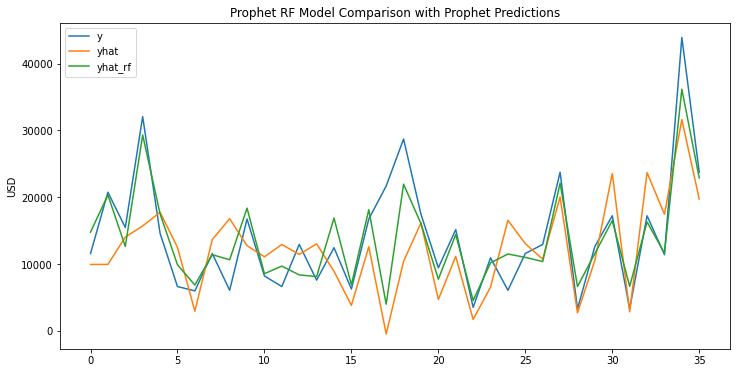

In [457]:
# plot results
results = X_test
results['yhat_rf'] = pred
final_results = results.merge(right=results_prophet, left_on = 'yhat',right_on='yhat')
final_results[['y','yhat','yhat_rf']].plot(
    title='Prophet RF Model Comparison with Prophet Predictions', 
    figsize=(12,6),
    ylabel='USD'
)

Just by looking at predictions, the Prophet-RF model (yhat_rf) is a closer match to the actual sales (y) than the Prophet model alone (yhat). 

#### Cross validate prophet results dataset

In [464]:
n_folds = 10
mae_rf = []
mae_p = []
mape_rf = []
mape_p = []

# loop thru each fold and randomly split data into test-train. Then get MAE for each fold.
for i in range(n_folds):
    # split into training/testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

    # train model and make predictions
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)

    # get results
    mae_rf.append(mean_absolute_error(y_test, pred))
    mape_rf.append(mean_absolute_percentage_error(y_test, pred))
    mae_p.append(X_test.merge(right=results_prophet, left_on='yhat',right_on='yhat').ae)
    mape_p.append(X_test.merge(right=results_prophet, left_on='yhat',right_on='yhat').ape)

# metrics averaged
mae_p = np.mean(np.array(mae_p))
mae_rf = np.mean(np.array(mae_rf))    
mape_p = np.mean(np.array(mape_p))
mape_rf = np.mean(np.array(mape_rf)) 

# show comparisons between models after 10 fold CV
model_comparisons = pd.DataFrame({'prophet':[mae_p,mape_p],'prophet_rf':[mae_rf,mape_rf]},index=['MAE','MAPE'])

model_comparisons

,prophet,prophet_rf
MAE,4970.884594,3017.192909
MAPE,0.528485,0.355380


Using 10 fold CV, we can see that the Prophet-Random Forest model has outperformed the Prophet model alone. This has resulted in a reduction of error of 39% and an decreased MAPE of 17%.

# Final Model: Predictions for next 3 months.

In [ ]:
def prophet_rf(train_df, test_df):
    final_result = []
    for region in train_dict.keys():
        yhat = []
        y = []
        month = []
        pred_len = []
        train = train_df[region]
        test = test_df[region]
        for i in range(len(train)):
            m = Prophet()
            m.fit(train[i])
            pred = m.predict(test[i])
            yhat.append(pred.yhat)
            y.append(test[i])
            month.append(test[i].ds.dt.month)
            pred_len.append(pd.DataFrame([1,2,3]))

        yhat = pd.concat(yhat).rename('yhat')
        month = pd.concat(month).rename('month')
        pred_len = pd.concat(pred_len)

        result = pd.concat(y)
        result['region'] = region
        result['yhat'] = yhat.values
        result['month'] = month.values
        result['pred_len'] = pred_len.values
        
        result['e'] = result.y - result.yhat    
        result['ae'] = abs(result.e)
        result['ape'] = abs(result.y - result.yhat)/result.y
        final_result.append(result)
    
    final_result = pd.concat(final_result)
    
    return final_result